In [4]:
# Install and set up Kaggle dataset

!pip install kaggle

!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d omkargurav/face-mask-dataset--force















cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!kaggle datasets download -d omkargurav/face-mask-dataset--force

403 - Forbidden - Permission 'datasets.get' was denied


In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-mask-dataset


In [2]:


# Import required libraries

import os

import numpy as np

import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator



# Load dataset

with_mask_files = os.listdir('/kaggle/input/face-mask-dataset/data/with_mask')

without_mask_files = os.listdir('/kaggle/input/face-mask-dataset/data/without_mask')



print('Number of with mask images:', len(with_mask_files))

print('Number of without mask images:', len(without_mask_files))

Number of with mask images: 3725
Number of without mask images: 3828


In [3]:


# Create labels

with_mask_labels = [1] * len(with_mask_files)

without_mask_labels = [0] * len(without_mask_files)

labels = with_mask_labels + without_mask_labels



# Convert images to numpy arrays

data = []

with_mask_path = '/kaggle/input/face-mask-dataset/data/with_mask/'

without_mask_path = '/kaggle/input/face-mask-dataset/data/without_mask/'



for img_file in with_mask_files:

    image = Image.open(with_mask_path + img_file).resize((128, 128)).convert('RGB')

    data.append(np.array(image))



for img_file in without_mask_files:

    image = Image.open(without_mask_path + img_file).resize((128, 128)).convert('RGB')

    data.append(np.array(image))

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [4]:
type(data)

list

In [5]:
len(data)

7553

In [6]:
data[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [254, 254, 254],
        [253, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [252, 253, 254],
        [246, 139, 136],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [212, 175, 154],
        [218, 187, 172],
        [250, 247, 245]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [212, 175, 154],
        [220, 191, 175],
        [252, 250, 248]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [211, 174, 155],
        [219, 194, 180],
        [252, 251, 250]]

In [7]:
type(data[0])

numpy.ndarray

In [8]:
data[0].shape

(128, 128, 3)

In [9]:
X = np.array(data)

Y = np.array(labels)

In [10]:
print(X.shape)
print(Y.shape)

(7553, 128, 128, 3)
(7553,)


In [11]:




# Split the dataset

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)



# Scale the data

X_train_scaled = X_train / 255.0

X_test_scaled = X_test / 255.0



# Data Augmentation

datagen = ImageDataGenerator(

    rotation_range=30,         # Random rotation

    width_shift_range=0.2,     # Random horizontal shift

    height_shift_range=0.2,    # Random vertical shift

    shear_range=0.2,           # Shearing transformation

    zoom_range=0.2,            # Zoom in/out

    horizontal_flip=True,      # Random horizontal flip

    brightness_range=(0.8, 1.2),  # Brightness adjustment

    fill_mode='nearest'        # Fill pixels for transformations

)



# Fit the generator to training data

#datagen.fit(X_train_scaled)


In [12]:
print(X_train_scaled.shape)

(6042, 128, 128, 3)


In [13]:
# Generate augmented data

augmented_data = []

augmented_labels = []



for X_batch, Y_batch in datagen.flow(X_train_scaled, Y_train, batch_size=len(X_train_scaled), shuffle=False):

    augmented_data.extend(X_batch)

    augmented_labels.extend(Y_batch)

    break  # Generate only one complete augmented batch



# Combine original and augmented data

X_combined = np.concatenate((X_train_scaled, np.array(augmented_data)))

Y_combined = np.concatenate((Y_train, np.array(augmented_labels)))



print("Original + Augmented Dataset Size:", X_combined.shape, Y_combined.shape)


Original + Augmented Dataset Size: (12084, 128, 128, 3) (12084,)


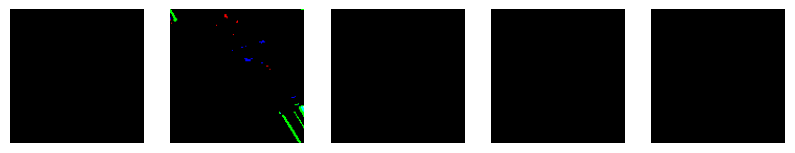

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Visualize augmented images

augmented_images = next(datagen.flow(X_train_scaled, Y_train, batch_size=5))

plt.figure(figsize=(10, 10))

for i in range(5):

    plt.subplot(1, 5, i + 1)

    plt.imshow(augmented_images[0][i])

    plt.axis('off')

plt.show()



# Build the CNN model

model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),

    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),

    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(2, activation='softmax')  # Use softmax for classification

])



# Compile the model

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



# Train the model with data augmentation

#history = model.fit(

    #datagen.flow(X_train_scaled, Y_train, batch_size=32),

    #validation_data=(X_test_scaled, Y_test),

    #epochs=10

#)

In [20]:
history = model.fit(X_combined, Y_combined, validation_split=0.2, epochs=10)


Epoch 1/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8664 - loss: 0.2150

I0000 00:00:1733381467.225849      69 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 64 bytes spill stores, 64 bytes spill loads



303/303 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8664 - loss: 0.2150 - val_accuracy: 0.6260 - val_loss: 0.7802
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8564 - loss: 0.2194 - val_accuracy: 0.6247 - val_loss: 0.8134
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8556 - loss: 0.2139 - val_accuracy: 0.6247 - val_loss: 0.7336
Epoch 4/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8596 - loss: 0.2027 - val_accuracy: 0.5594 - val_loss: 0.7581
Epoch 5/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8560 - loss: 0.2142 - val_accuracy: 0.6285 - val_loss: 0.7582
Epoch 6/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8568 - loss: 0.2190 - val_accuracy: 0.6247 - val_loss: 0.8574
Epoch 7/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8619 - loss: 0.1963 - val_accuracy: 0.6252 - val_loss: 0.8969
Epoch 8/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8580 - loss: 0.2078 - val_accuracy: 0.625

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9366 - loss: 0.2975
Test Accuracy: 0.9444077014923096


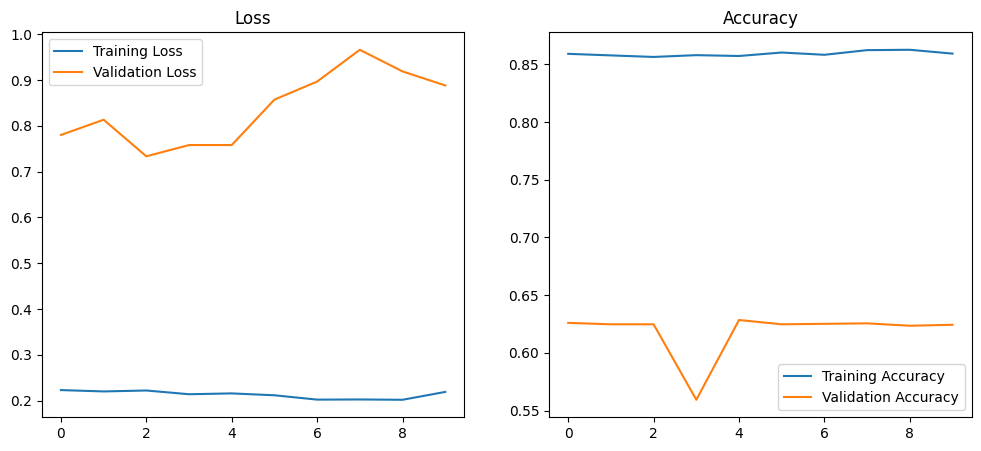

In [21]:
# Evaluate the model

loss, accuracy = model.evaluate(X_test_scaled, Y_test)

print('Test Accuracy:', accuracy)



# Plot loss and accuracy

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

plt.plot(history.history['loss'], label='Training Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')

plt.legend()

plt.title('Loss')



plt.subplot(1, 2, 2)

plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.legend()

plt.title('Accuracy')

plt.show()

Path of the image to be predicted:  /kaggle/input/test12/TEST1.png


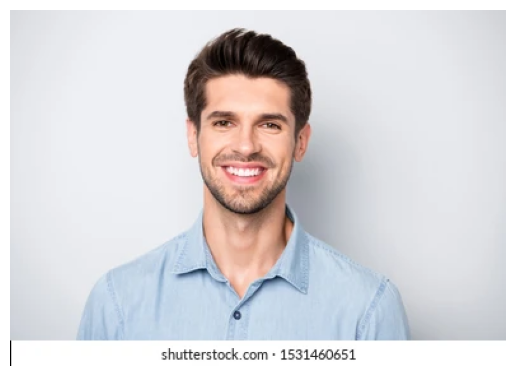

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.9941242  0.00587584]]
The person in the image is not wearing a mask.


In [22]:
import cv2
#from google.colab.patches import cv2_imshow
import cv2
import cv2
import matplotlib.pyplot as plt





# Predict on an input image

input_image_path = input('Path of the image to be predicted: ')

input_image1 = cv2.imread(input_image_path)

if input_image1 is None:
    print("Error: Could not load the image. Please check the file path.")
else:
    # Convert BGR (OpenCV format) to RGB (Matplotlib format)
    input_image_rgb = cv2.cvtColor(input_image1, cv2.COLOR_BGR2RGB)
    
    # Display the image using Matplotlib
    plt.imshow(input_image_rgb)
    plt.axis('off')  # Turn off axis
    plt.show()



input_image = Image.open(input_image_path).resize((128, 128)).convert('RGB')

input_image_array = np.array(input_image) / 255.0

input_image_reshaped = np.reshape(input_image_array, (1, 128, 128, 3))



prediction = model.predict(input_image_reshaped)
print(prediction)

predicted_label = np.argmax(prediction)




if predicted_label == 1:

    print('The person in the image is wearing a mask.')

else:

    print('The person in the image is not wearing a mask.')